# **What will you learn?**

In this demo, we will learn how to build a simple outlier detection system, which includes 8 components as follows.

*  Data loading

*  Data pre-processing

*  Feature enhancement (NR [1])

*  Outlier detector (LOF [2] and IF [3] based on scikit-learn, a python library)

*  Score post-processing (NA [4])

*  Score thresholding (MAD [5])

*  Result evaluation

*  Result visualization  



References:

[1] Jiawei Yang et al., Neighborhood representative for improving outlier detectors, Information Sciences, 2023.

[2] M. M. Breunig et al. LOF: identifying density-based local outliers. ACM SIGMOD, 2000.

[3] F. T. Liu et al, Isolation forest. IEEE ICDM, 2008.

[4] Jiawei Yang et al., Smoothing Outlier Scores is All You Need to Improve Outlier Detectors, IEEE TKDE, 2023.

[5] Jiawei Yang et al., Outlier detection: how to threshold outlier scores? AIIPCC, 2019.



# **What is your task?**
You need to insert your codes to the functions below to reproduce the results in demo 2.


*   cal_NA(score,neighbor,k)
*   find_representative(points, k)





In [4]:
import numpy as np
import scipy.stats as ss
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor # outlier detector
from sklearn.ensemble import IsolationForest # outlier detector
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
np.random.seed(0)

path='demo_data/' # path for datasets


def cal_NA(score,neighbor,k):
     # for NA. For each point, its revised score is the mean of its score with its k-NN's scores.
     #please insert your code here

    # initializing an array, revised_score, with the same shape as score to store the new, adjusted scores
    revised_score = np.zeros_like(score)
    
    for i in range(len(score)):
        # Getting the scores of the k nearest neighbors for point i.
        neighbor_scores = score[neighbor[i]]
        # Computing the mean including the point's own score.
        revised_score[i] = (score[i] + np.sum(neighbor_scores)) / (len(neighbor[i]) + 1)
    return revised_score


def find_representative(points, k):
    # for NR. For each point, it finds its medoid of kNN as its representative.
    #pleae insert your code here

    m, n = points.shape
    representative_points = np.zeros_like(points)
    
    # Fitting a nearest neighbor model.
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(points)
    distances, indices = nbrs.kneighbors(points)
    
    for i in range(m):
        # Excluding the point itself from the k-nearest neighbors.
        knn_indices = indices[i, 1:]
        knn_points = points[knn_indices]
        
        # Computing pairwise Euclidean distances among the k nearest neighbors.
        dists = np.linalg.norm(knn_points[:, np.newaxis, :] - knn_points[np.newaxis, :, :], axis=2)
        
        # Summing distances for each candidate neighbor to all others.
        total_dists = np.sum(dists, axis=1)
        
        medoid_local_idx = np.argmin(total_dists)
        representative_points[i] = knn_points[medoid_local_idx]
    
    return representative_points

def norm_data(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

def get_KNN(data,k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data) #'auto', 'ball_tree', 'kd_tree', 'brute']
    dist, ind = nbrs.kneighbors(data)
    return ind

def k_nearest_neighbor(point, nbrs,points):
    distances, indices = nbrs.kneighbors([point])
    k_smallest = []
    for i,p in enumerate(indices[0]):
        k_smallest.append(points[p])
    k_smallest.pop(0)
    return k_smallest

def cal_score_LOF(data,k):
    outlier_detector=LocalOutlierFactor(n_neighbors=k)
    outlier_detector.fit_predict(data)
    return -outlier_detector.negative_outlier_factor_

def cal_score_IF(data):
    outlier_detector = IsolationForest(random_state = 0)
    outlier_detector.fit(data)
    return -outlier_detector.decision_function(data)


def plt_data(data,label):
    fig, axs = plt.subplots()
    normality=data[np.where(label==0)]
    outlier=data[np.where(label==1)]
    x,y=np.array(normality).T
    plt.scatter(x, y, s = 10,c='black',label='Normalities')
    x,y=np.array(outlier).T
    plt.scatter(x, y, s = 10,c='red',label='Outliers')
    axs.set_aspect('equal')
    plt.legend()
    plt.show()


def plt_data_score(data,score):
    fig, axs = plt.subplots()
    x,y=np.array(data).T
    plt.scatter(x, y, s = 10,c=score)
    axs.set_aspect('equal')
    plt.colorbar(cmap='jet')
    plt.show()

def cal_MAD(score):
    m=np.median(score)
    mad=np.median(abs(score-m))
    return m+5*1.4826*mad

# **Demo 1**
In the first demo, you will play around the outlier detection with a toy dataset. You will not need to do anythihng but run the codes.

[[-0.19832125  0.48484578  0.        ]
 [-0.19780602 -0.56432921  0.        ]
 [-0.39484274  0.38141958  0.        ]
 [ 0.22341487  0.47172809  0.        ]
 [ 0.45472511  0.07108074  0.        ]]


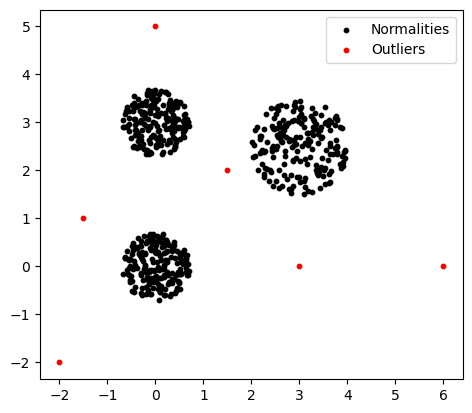

In [7]:
# demo 1 with toy dataset

#load data
data_with_label=np.genfromtxt(path+'demo_data1.txt', delimiter=',')
print(data_with_label[:5,:])
data=data_with_label[:,:2]
label=data_with_label[:,[-1]].reshape(data_with_label.shape[0]).astype(int)


#plot data
plt_data(data,label)

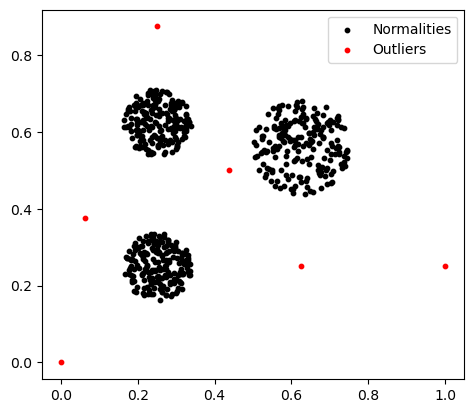

In [9]:
# normalize data

data_norm=norm_data(data)
plt_data(data_norm,label)

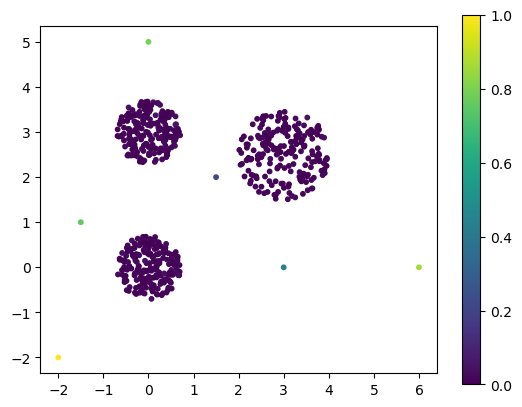

In [11]:
#compute outlier score using LOF
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html


outlier_detector=LocalOutlierFactor(n_neighbors=5)
outlier_detector.fit_predict(data)
outlier_score_LOF=-outlier_detector.negative_outlier_factor_

#plot score
outlier_score_LOF_norm=norm_data(outlier_score_LOF)
plt_data_score(data,outlier_score_LOF_norm)

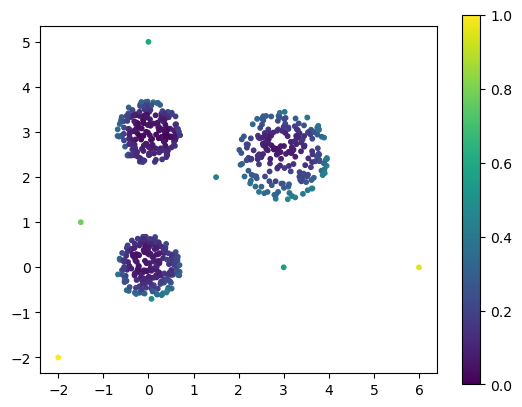

In [13]:
#compute outlier score using Isolation Forest
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

outlier_detector = IsolationForest(random_state = 0)
outlier_detector.fit(data)
outlier_score_IF = -outlier_detector.decision_function(data)

outlier_score_IF_norm=norm_data(outlier_score_IF)
plt_data_score(data,outlier_score_IF_norm)

In [15]:
# evaluate the results with AUROC
print('AUROC for LOF: ',roc_auc_score(label,outlier_score_LOF))
print('AUROC for IF: ',roc_auc_score(label,outlier_score_IF))

AUROC for LOF:  1.0
AUROC for IF:  0.9983333333333333


In [17]:
# evaluate the results with F1-score

print('tresholdig method 1: MAD')


t_IF=cal_MAD(outlier_score_IF_norm)
label_pred_IF=np.array([1 if i >t_IF else 0 for i in outlier_score_IF_norm ])

t_LOF=cal_MAD(outlier_score_LOF_norm)
label_pred_LOF=np.array([1 if i >t_LOF else 0 for i in outlier_score_LOF_norm ])

print('index of outliers by IF',np.where(label_pred_IF==1))
print('index of outliers by LOF',np.where(label_pred_LOF==1))

print('t_IF=',t_IF)
print('t_LOF=',t_LOF)

print('F1-score for IF: ',f1_score(label, label_pred_IF, average=None)[0])
print('F1-score for LOF: ',f1_score(label, label_pred_LOF, average=None)[0])


tresholdig method 1: MAD
index of outliers by IF (array([601, 603, 605], dtype=int64),)
index of outliers by LOF (array([ 52,  72,  76, 116, 171, 177, 203, 315, 339, 404, 473, 486, 512,
       600, 601, 602, 603, 604, 605], dtype=int64),)
t_IF= 0.6183354927068399
t_LOF= 0.03427763850887946
F1-score for IF:  0.9975062344139651
F1-score for LOF:  0.9890480202190396


In [19]:
print('tresholdig method 2: top_k')
top_k=6
label_pred_IF=np.zeros(data.shape[0])
outlier_idx_IF=np.argpartition(outlier_score_IF_norm,-top_k)[-top_k:]
label_pred_IF[outlier_idx_IF]=np.ones(len(outlier_idx_IF))

label_pred_LOF=np.zeros(data.shape[0])
outlier_idx_LOF=np.argpartition(outlier_score_LOF_norm,-top_k)[-top_k:]
label_pred_LOF[outlier_idx_LOF]=np.ones(len(outlier_idx_LOF))

print('index of outliers by IF',outlier_idx_IF)
print('index of outliers by LOF',outlier_idx_LOF)

print('F1-score for IF: ',f1_score(label, label_pred_IF, average=None)[0])
print('F1-score for LOF: ',f1_score(label, label_pred_LOF, average=None)[0])

tresholdig method 2: top_k
index of outliers by IF [ 52 604 602 603 601 605]
index of outliers by LOF [600 601 602 603 604 605]
F1-score for IF:  0.9983333333333333
F1-score for LOF:  1.0


To summarize, it needs to apply the thresholding technique to outlier scores to compute the F1-score, a label-based evaluation metric. Different thresholding techniques may lead to different evaluation results. To avoid this issue, ranking-based evaluation metrics are normally employed such as AUROC or AUPRC.

# **Demo 2**
In the following demo, you need to insert you codes to below functions, located at the top of this file, so that the figures can be reproduced.

*  cal_NA(score,neighbor,k)
*  find_representative(points, k)


In [23]:
# demo 2 with real-word dataset


# load "Parkinson" dataset
# datasets: https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/

data_with_label2=np.genfromtxt(path+'demo_Parkinson.txt', delimiter=',')
data2=data_with_label2[:,0:data_with_label2.shape[1]-1]
label2=data_with_label2[:,[-1]].reshape(data_with_label2.shape[0]).astype(int)
print(data_with_label2.shape,data2.shape,label2.shape,np.sum(label2))

(195, 23) (195, 22) (195,) 147


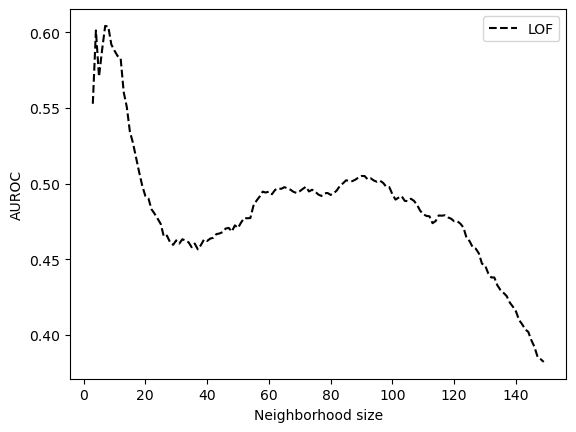

In [25]:
#LOF

def cal_score_LOF(data,k):
    clf=LocalOutlierFactor(n_neighbors=k)
    clf.fit_predict(data)
    return -clf.negative_outlier_factor_

auroc_arr_LOF=[]
for k in range(3,150):
    outlier_score_LOF=cal_score_LOF(data2,k)
    auroc_arr_LOF.append(roc_auc_score(label2,outlier_score_LOF))

#plot results
plt.plot(range(3,150), auroc_arr_LOF,'--',color='black',label='LOF')
plt.xlabel('Neighborhood size')
plt.ylabel('AUROC')
plt.legend()
plt.show()

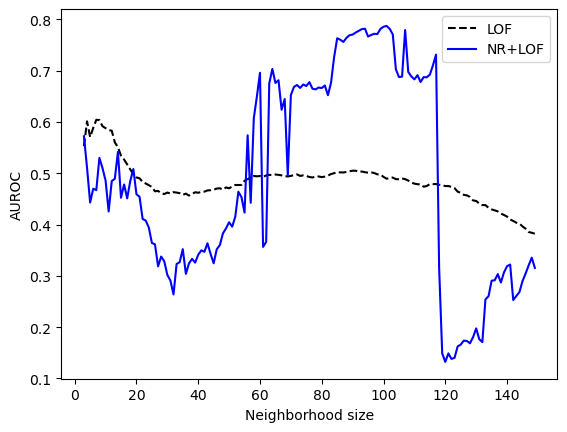

In [27]:
# NR + LOF
auroc_arr_NR_LOF=[]
for k in range(3,150):
    representative_points=find_representative(data2, k)

    outlier_score_LOF=cal_score_LOF(representative_points,k)

    auroc_arr_NR_LOF.append(roc_auc_score(label2,outlier_score_LOF))

#plot results
plt.plot(range(3,150), auroc_arr_LOF,'--',color='black',label='LOF')
plt.plot(range(3,150), auroc_arr_NR_LOF,color='blue',label='NR+LOF')
plt.xlabel('Neighborhood size')
plt.ylabel('AUROC')
plt.legend()
plt.show()

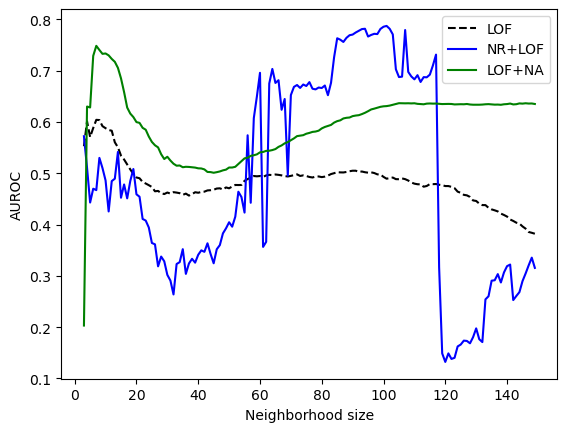

In [29]:
# LOF +NA
auroc_arr_LOF_NA=[]
neighbor=get_KNN(data2,150)
for k in range(3,150):
    outlier_score_LOF=cal_score_LOF(data2,k)

    outlier_score_LOF_NA=cal_NA(outlier_score_LOF,neighbor,k)
    auroc_arr_LOF_NA.append(roc_auc_score(label2,outlier_score_LOF_NA))

#plot results
plt.plot(range(3,150), auroc_arr_LOF,'--',color='black',label='LOF')
plt.plot(range(3,150), auroc_arr_NR_LOF,color='blue',label='NR+LOF')
plt.plot(range(3,150), auroc_arr_LOF_NA,color='green',label='LOF+NA')
plt.xlabel('Neighborhood size')
plt.ylabel('AUROC')
plt.legend()
plt.show()

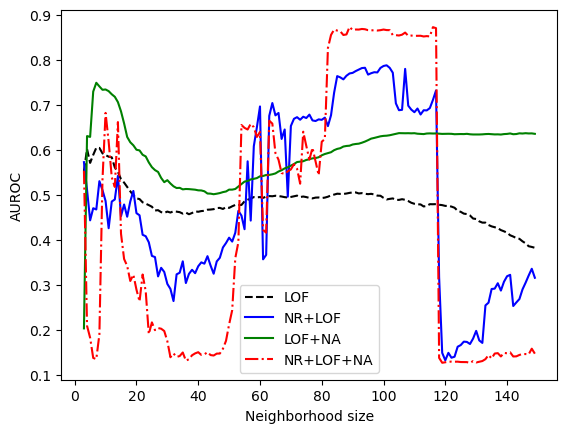

max AUROC of 'LOF' 0.604
max AUROC of 'NR+LOF' 0.787
max AUROC of 'LOF+NA' 0.749
max AUROC of 'NR+LOF+NA' 0.873


In [31]:
# NR+ LOF +NA

auroc_arr_LOF,auroc_arr_NR_LOF,auroc_arr_LOF_NA,auroc_arr_NR_LOF_NA=[],[],[],[]
neighbor=get_KNN(data2,150)
for k in range(3,150):

    # outlier score of LOF
    score_LOF=cal_score_LOF(data2,k)

    # outlier score of LOF+NA
    score_LOF_NA=cal_NA(score_LOF,neighbor,k)

    ## outlier score of NR+LOF
    representative_points=find_representative(data2, k)
    score_NR_LOF=cal_score_LOF(representative_points,k)

    # outlier score of NR+LOF+NA
    score_NR_LOF_NA=cal_NA(score_NR_LOF,neighbor,k)

    auroc_arr_LOF.append(roc_auc_score(label2,score_LOF))
    auroc_arr_NR_LOF.append(roc_auc_score(label2,score_NR_LOF))
    auroc_arr_LOF_NA.append(roc_auc_score(label2,score_LOF_NA))
    auroc_arr_NR_LOF_NA.append(roc_auc_score(label2,score_NR_LOF_NA))

#plot results
plt.plot(range(3,150), auroc_arr_LOF,'--',color='black',label='LOF')
plt.plot(range(3,150), auroc_arr_NR_LOF,color='blue',label='NR+LOF')
plt.plot(range(3,150), auroc_arr_LOF_NA,color='green',label='LOF+NA')
plt.plot(range(3,150), auroc_arr_NR_LOF_NA,'-.',color='red',label='NR+LOF+NA')

plt.xlabel('Neighborhood size')
plt.ylabel('AUROC')
plt.legend()
plt.show()
print("max AUROC of 'LOF'",np.round(np.max(auroc_arr_LOF),3))
print("max AUROC of 'NR+LOF'",np.round(np.max(auroc_arr_NR_LOF),3))
print("max AUROC of 'LOF+NA'",np.round(np.max(auroc_arr_LOF_NA),3))
print("max AUROC of 'NR+LOF+NA'",np.round(np.max(auroc_arr_NR_LOF_NA),3))


To summarize, with the NR and NA components, the LOF detector can be significantly improved from 0.604 AUROC to 0.916 AUROC.